# FIGURE 4
**Comparison of projections over COG-functional-cathegories of functional-displacement-vectors**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

functional_table = pd.read_parquet("../DATA/datasets/remapped/functional_table.parq")
ishealthy = pd.read_parquet("../DATA/metadata/remapped/sample_health.parq")["ishealthy"]
fg_annot  = pd.read_parquet("../DATA/metadata/remapped/functional_groups_mapping.parq").loc[functional_table.index]

from utils import compute_svd_decomposition, project_on_subspace, reconstruct_from_subspace

## Compute

In [2]:
def select_C_hyperparameter(dataset,ishealthy,log10range=(-4,1),npoints=20,show=False):
    from sklearn import svm
    from sklearn.model_selection import GridSearchCV

    # define model, parameter space on which to search, and grid-search-5fold-cv helper
    SVM = svm.SVC(kernel="linear",class_weight="balanced") # initialize linear SVM architecture
    C = np.logspace(log10range[0],log10range[1],npoints)
    GS  = GridSearchCV(estimator=SVM,param_grid={"C":C},refit=False,cv=None,verbose=0,n_jobs=3)

    # run gridsearch
    X = dataset.T                  # setup dataset as training set
    y = ishealthy                  # setup healthy parameter as labels
    GS.fit(X,y)                    # fit grid search

    # GS results
    mean = pd.DataFrame(GS.cv_results_)["mean_test_score"]
    std = pd.DataFrame(GS.cv_results_)["std_test_score"]
    param_C = pd.DataFrame(GS.cv_results_)["param_C"]
    rank = pd.DataFrame(GS.cv_results_)["rank_test_score"]
    C = param_C[np.argmax(mean)]

    ## display GS results
    if show:
        print(f"best C = {C}")
        plt.errorbar(x=param_C,y=mean,yerr=std)
        plt.xscale("log")
        plt.xlabel("C values")
        plt.ylabel("accuracy")

    return C


def discriminant_direction_SVM(dataset,ishealthy,C="compute"):

    ## FROM SEPARATING HYPERPLANE DEFINED BY SVM PROCEDURE
    from sklearn import svm
    from sklearn.model_selection import GridSearchCV
    
    # Parameter selection
    if   (C=="compute-show"): C = select_C_hyperparameter(dataset,ishealthy,show=True )
    elif (C=="compute")     : C = select_C_hyperparameter(dataset,ishealthy,show=False)

    # compute separating hyperplate with SVM
    SVM = svm.SVC(kernel="linear",C=C,class_weight="balanced") # initialize linear SVM architecture
    X = dataset.T                                              # setup dataset as training set
    y = ishealthy                                              # setup health parameter as labels
    SVM.fit(X,y)                                               # fit SVM
    
    # discrimnant direction vector
    ddir  = -SVM.coef_[0]          # extract vector from SVM parameters
    ddir /= np.sum(np.abs(ddir))   # L1 normalization

    return ddir



def discriminant_direction_MAD(dataset,ishealthy,logdiff=False):
    if logdiff:
        fraction = dataset.loc[:,~ishealthy].mean(axis=1)/dataset.loc[:, ishealthy].mean(axis=1)
        ddir  = np.where(np.isfinite(fraction),np.log10(fraction),0) # define vector as log MAD difference (log(U)-log(H))
    else:
        ddir  = dataset.loc[:,~ishealthy].mean(axis=1) - dataset.loc[:,ishealthy].mean(axis=1) # define vector as MAD difference (U-H)
    
    ddir /= np.sum(np.abs(ddir))                                                           # L1 normalization
    return ddir

### Compute all

In [3]:
def compute_figure_4(dataset,ishealthy,functional_groups_annotations,null_rep=150,C=0.24,SVD_reduction=None,logdiff=False):

    # good values of C are: 0.00695 without SVD reduction
    #                       0.00695 with SVD reduction on ~> 50 components
    #                       0.24    with SVD reduction on 20 components

    if SVD_reduction is not None:
        SVD = compute_svd_decomposition(dataset)
        dataset_proj = project_on_subspace(dataset,SVD,n=SVD_reduction)



    # MAIN VALUES
    
    # compute discrimenant directions with MAD and SVM methods
    group_ddir = pd.DataFrame(index=functional_groups_annotations.columns)
    group_ddir["MAD"] =                            discriminant_direction_MAD(dataset     ,ishealthy,logdiff=logdiff)       @ functional_groups_annotations # from MAD comparison
    group_ddir["SVM"] =                            discriminant_direction_SVM(dataset     ,ishealthy,C)                     @ functional_groups_annotations if SVD_reduction is None else\
                         reconstruct_from_subspace(discriminant_direction_SVM(dataset_proj,ishealthy,C),SVD,add_mean=False) @ functional_groups_annotations # from SVM separating hyperplane


    ## NULL MODEL
    
    # allocate containers for replicas
    null_ddir_MAD = np.zeros(shape=(len(dataset     ),null_rep))
    null_ddir_SVM = np.zeros(shape=(len(dataset     ),null_rep)) if SVD_reduction is None else\
                    np.zeros(shape=(len(dataset_proj),null_rep))
    
    # iterate procedure over random H/U divisions
    for i in range(null_rep):
        null_ishealthy = np.random.permutation(ishealthy)
        null_ddir_MAD[:,i] = discriminant_direction_MAD(dataset     ,null_ishealthy)
        null_ddir_SVM[:,i] = discriminant_direction_SVM(dataset     ,null_ishealthy,C) if SVD_reduction is None else\
                             discriminant_direction_SVM(dataset_proj,null_ishealthy,C)
    
    # project over functional groups
    group_null_ddir_MAD = functional_groups_annotations.T @                           null_ddir_MAD
    group_null_ddir_SVM = functional_groups_annotations.T @                           null_ddir_SVM                     if SVD_reduction is None else\
                          functional_groups_annotations.T @ reconstruct_from_subspace(null_ddir_SVM,SVD,add_mean=False)
    
    # compute average and std+-
    group_ddir["MAD_null_mean"] = group_null_ddir_MAD.mean(axis=1)
    group_ddir["SVM_null_mean"] = group_null_ddir_SVM.mean(axis=1)
    group_ddir["MAD_null_std"]  = group_null_ddir_MAD.std(axis=1)
    group_ddir["SVM_null_std"]  = group_null_ddir_SVM.std(axis=1)
    
    # asymmetric std
    #group_ddir["MAD_null_std-"],group_ddir["MAD_null_std+"] = asymmetric_std(group_null_ddir_MAD)
    #group_ddir["SVM_null_std-"],group_ddir["SVM_null_std+"] = asymmetric_std(group_null_ddir_SVM)


    return group_ddir

DATA = compute_figure_4(functional_table,ishealthy,fg_annot,SVD_reduction=50)

## Plot

In [4]:
# define plotting function to be applied on MAD and SVM data
def visualize_group_discriminant_direction(ax,group_ddir,kind="MAD",relative=False,color=None):

    assert kind=="MAD" or kind=="SVM"

    x       = np.arange(len(group_ddir))                              # center like
    x_edges = np.linspace(-0.5,len(group_ddir)-0.5,len(group_ddir)+1) # bin-edges like
    y  = group_ddir[f"{kind}"]
    y0 = group_ddir[f"{kind}_null_mean"]
    y1 = group_ddir[f"{kind}_null_mean"]-group_ddir[f"{kind}_null_std"]
    y2 = group_ddir[f"{kind}_null_mean"]+group_ddir[f"{kind}_null_std"]

    if relative:
        y  = (y  - y0) / group_ddir[f"{kind}_null_std"]
        y1 = (y1 - y0) / group_ddir[f"{kind}_null_std"]
        y2 = (y2 - y0) / group_ddir[f"{kind}_null_std"]
        y0 = (y0 - y0) / group_ddir[f"{kind}_null_std"]

    null_handler1 = ax.stairs(y2, x_edges, baseline=y1, fill=True,color="grey", alpha=0.3) # null model $(\pm1\sigma)$"
    null_handler2 = ax.stairs(y0, x_edges, color="grey",linestyle="--",linewidth=0.6)
    bar_handler = ax.bar(x=x,height=y,alpha=0.7,color=color)
    ax.legend([(null_handler1,null_handler2),bar_handler], ["null model","projection"],fancybox=True, shadow=True,loc="lower right")

    ax.set_xticks(ticks=x,labels=group_ddir.index)
    ax.set_xlabel("COG functional categories")
    ax.set_ylabel("Projection")

### Plot all

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


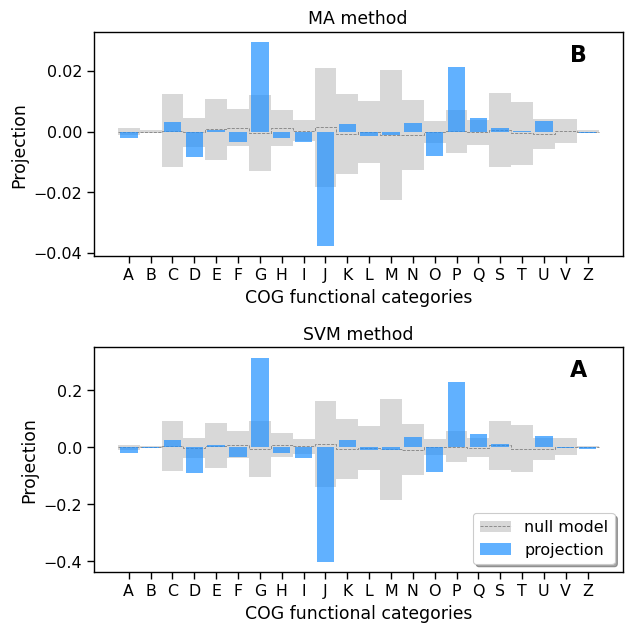

In [5]:
def plot_figure_4(DATA,savepath=None,relative=False):

    import seaborn as sns
    sns.set_context('paper', font_scale=1.3)
    
    # unpack data
    group_ddir = DATA

    # select color
    color = "dodgerblue"#"limegreen"

    # figure management
    fig, axs = plt.subplots(2,1,figsize=[6.5,6.5])
    axs = axs[::-1]

    # make subplots for MAD and SVM
    visualize_group_discriminant_direction(axs[0],group_ddir,kind="SVM",color=color,relative=relative)
    visualize_group_discriminant_direction(axs[1],group_ddir,kind="MAD",color=color,relative=relative)
    
    # tweak
    #axs[0].legend().set_visible(True)
    axs[1].legend().set_visible(False)
    axs[0].set_title("SVM method")
    axs[1].set_title("MA method")
    #axs[0].set_xlabel(axs[0].set_xlabel(),fontsize=22)
    plt.tight_layout()  

    # subplot name patches
    for ax,label in zip(axs.ravel(),('A', 'B')):
        ax.text(x=0.90, y=0.95, s=label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')  

    # export images/display
    if savepath is not None: plt.savefig(fname=savepath, dpi="figure", format="pdf")
    plt.show()

# plot/save
savepath=f"../RESULTS/Figure_4_discriminant_drection.pdf"
plot_figure_4(DATA,savepath=savepath,relative=False)